In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LONG_PCT = 0.2
SHORT_PCT = 0.2
LEVERAGE = 1.0
HOLDING_WEEKS = 1
equal_weight = False  # Set to True for equal-weighted portfolio
# Input Paths
SENTIMENT_2022 = "../data/daily_absa_2022.csv"
SENTIMENT_2024 = "../data/daily_absa_2024.csv"

SENTIMENT_paths = ["../data/ellen_score_2024.csv"]
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = 'momentum/s&p500ret.csv' 
SP500_RET_PATH = "../data/snp500_ret.csv"    # Path to index returns

# --------------------------------------------------------------------------------
# 1. DATA LOADING & ENTITY MATCHING
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    """
    Loads and concatenates daily sentiment files.
    """
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading sentiment: {path}")
            df = pd.read_csv(path)
            dfs.append(df)
        else:
            print(f"Warning: File not found {path}")
            
    if not dfs:
        return pd.DataFrame()
        
    combined = pd.concat(dfs, ignore_index=True)
    
    # Basic cleanup
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps sentiment 'entity' names to S&P 500 Tickers.
    """
    if not os.path.exists(SP500_MAPPING):
        print(f"Warning: Mapping file not found at {SP500_MAPPING}")
        return sentiment_df

    sp500 = pd.read_excel(SP500_MAPPING)
    
    # Case 1: Entity is the Ticker (common in financial datasets)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    
    # Filter to only include tickers present in our SP500 universe
    valid_tickers = set(sp500['Ticker'].unique())
    mapped_df = sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()
    
    print(f"Mapped {len(mapped_df)} rows to valid S&P 500 tickers.")
    return mapped_df

def parse_sentiment_string(val):
    """
    Parses stringified dict "{'positive': 0.1, ...}" into a float score.
    Score = Prob(Positive) - Prob(Negative)
    """
    if isinstance(val, (int, float)):
        return val
    
    if isinstance(val, str):
        try:
            # Convert string "{...}" to dict
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                pos = d.get('positive', 0)
                neg = d.get('negative', 0)
                return pos - neg
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates daily sentiment to Weekly (Fri-Fri).
    """
    daily_df = daily_df.copy()
    
    # Group by Week Ending Friday
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    # Detect the sentiment column
    target_col = None
    possible_cols = ['softmax', 'sentiment', 'score', 'SENT'] 
    
    for col in possible_cols:
        if col in daily_df.columns:
            target_col = col
            break
            
    if target_col is None:
        print(f"Warning: Sentiment column not found. Available: {daily_df.columns}")
        return pd.DataFrame()

    print(f"Using '{target_col}' as the raw sentiment signal.")

    # --- FIX: Parse string dictionaries if detected ---
    # Check the first valid value to see if it's a string
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    
    if isinstance(first_valid, str) and '{' in first_valid:
        print(f"Parsing stringified dictionaries in column '{target_col}'...")
        # Apply parsing logic to create a numeric score
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)

    # Ensure column is numeric now
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')

    # Aggregate
    weekly_signal = (
        daily_df.groupby(['TICKER', 'week_date'])[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: 'SENT'})
    )
    
    return weekly_signal

# --------------------------------------------------------------------------------
# 2. MARKET DATA PREP
# --------------------------------------------------------------------------------

def load_stock_returns(csv_path: str = STOCK_RET_PATH) -> pd.DataFrame:
    """
    Loads daily stock returns and compounds them to weekly.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Stock returns not found at {csv_path}")
        return pd.DataFrame(columns=['week_date', 'TICKER', 'RET'])

    df = pd.read_csv(csv_path)
    
    # Standardize names
    df.columns = [c.lower() for c in df.columns]
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Handle potential non-numeric returns
    if 'ret' in df.columns:
        df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    
    # Drop missing returns
    df = df.dropna(subset=['ret'])
    
    # Weekly Aggregation
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    weekly_ret = (
        df.groupby(['ticker', 'week_date'])['ret']
        .apply(lambda x: (1 + x).prod() - 1)
        .reset_index()
        .rename(columns={'ret': 'RET', 'ticker': 'TICKER'})
    )
    
    # Normalize Ticker
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    
    return weekly_ret

def load_sp500_weekly(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    """
    Loads S&P 500 index returns for benchmarking.
    """
    try:
        sp = pd.read_csv(csv_path)
        sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
        sp['date'] = pd.to_datetime(sp['date'])
        sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
        sp = sp.dropna(subset=['sp500_ret'])
        
        # Week ending Friday (Normalized to Midnight)
        sp['week_date'] = sp['date'].dt.to_period('W-FRI').dt.to_timestamp()

        weekly = (
            sp.groupby('week_date')['sp500_ret']
              .apply(lambda x: (1 + x).prod() - 1)
              .reset_index(name='sp500_ret')
        )
        
        weekly = weekly.sort_values('week_date')
        
        # Align Benchmark: Strategy at T predicts T+1. Benchmark must be T+1.
        weekly['sp500_ret_next'] = weekly['sp500_ret'].shift(-1)
        
        return weekly.dropna()
    except FileNotFoundError:
        print(f"Warning: S&P 500 file not found at {csv_path}.")
        return pd.DataFrame(columns=['week_date', 'sp500_ret', 'sp500_ret_next'])

# --------------------------------------------------------------------------------
# 3. DATA ALIGNMENT (LOOK-AHEAD BIAS REMOVAL)
# --------------------------------------------------------------------------------

def prepare_aligned_data(weekly_signal: pd.DataFrame, weekly_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Merges Signal (Week T) with Returns (Week T+1).
    This is the central point for preventing look-ahead bias.
    """
    # Merge on Ticker and Date
    df = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    
    # Sort strictly
    df = df.sort_values(['TICKER', 'week_date'])
    
    # ---------------------------------------------------------
    # SHIFT LOGIC:
    # We have Signal_T and Return_T on the same row.
    # We want to trade Signal_T to capture Return_{T+1}.
    # So we create 'RET_next' by shifting 'RET' backward by 1.
    # ---------------------------------------------------------
    df['RET_next'] = df.groupby('TICKER')['RET'].shift(-1)
    
    # Drop the last row (where we have a signal but no future return known yet)
    df = df.dropna(subset=['RET_next', 'SENT'])
    
    return df

# --------------------------------------------------------------------------------
# 4. BACKTEST ENGINE
# --------------------------------------------------------------------------------

def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE, 
                      equal_weight=True) -> pd.Series:
    """
    Calculates long/short weights based on signal ranking.
    """
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    
    ranked = sig.sort_values(ascending=False)
    long_cands = ranked.iloc[:n_long]
    short_cands = ranked.iloc[-n_short:]

    if equal_weight:
        w_long = pd.Series(1.0 / n_long, index=long_cands.index)
        w_short = pd.Series(-1.0 / n_short, index=short_cands.index)
    else:
        # Signal Weighted
        long_denom = long_cands.abs().sum()
        w_long = (long_cands.abs() / long_denom) if long_denom > 0 else pd.Series(1.0/n_long, index=long_cands.index)

        short_denom = short_cands.abs().sum()
        w_short = ((short_cands.abs() / short_denom) * -1) if short_denom > 0 else pd.Series(-1.0/n_short, index=short_cands.index)
        
    w = pd.concat([w_long, w_short])
    
    if w.abs().sum() > 0:
        w *= gross_leverage / w.abs().sum()
            
    return w

def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str,
                       equal_weight: bool = False) -> pd.DataFrame:
    
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    for i, w in enumerate(all_weeks):
        cs_slice = df[df['week_date'] == w]
        # Extract signal
        sig_cs = cs_slice.set_index('TICKER')[col_signal]
        
        w_cs = construct_weights(sig_cs, equal_weight=equal_weight)
        
        if w_cs.empty:
            continue

        # Holding Period Logic
        hold_weeks = all_weeks[i : i + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values / holding_weeks
            }))

    if recs:
        combined = pd.concat(recs, ignore_index=True)
        return combined.groupby(['week_date', 'TICKER'], as_index=False)['weight'].sum()
    else:
        return pd.DataFrame(columns=['week_date', 'TICKER', 'weight'])

def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    
    # Merge Weights (Time T) with Returns (Time T+1)
    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_next']], 
        on=['TICKER', 'week_date'],
        how='left'
    )
    
    merged['pnl'] = merged['weight'] * merged['RET_next']
    
    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl + short_pnl 
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    # Universe Benchmark
    benchmark = (
        df.groupby('week_date')['RET_next']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    # S&P 500 Benchmark
    sp500 = load_sp500_weekly()
    if not sp500.empty:
        pnl = pnl.merge(sp500[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        pnl = pnl.rename(columns={'sp500_ret_next': 'sp500_ret'})
        pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)
    else:
        pnl['sp500_ret'] = 0.0

    # Cumulative Value
    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()
    
    return pnl.dropna(subset=['port_ret'])


print("1. Loading Raw Sentiment Data...")
raw_sentiment = load_raw_sentiment()
print("2. Mapping Entities and Aggregating Signals...")
mapped_sentiment = map_entities_to_tickers(raw_sentiment)
weekly_signal = build_weekly_signal(mapped_sentiment)
print("3. Loading Market Data...")
weekly_returns = load_stock_returns()

analysis_df = prepare_aligned_data(weekly_signal, weekly_returns)


print(f"   Data ready. {len(analysis_df)} rows across {analysis_df['week_date'].nunique()} weeks.")

print("5. Running Backtest...")
weight_panel = build_weight_panel(analysis_df, holding_weeks=HOLDING_WEEKS, col_signal='SENT', equal_weight=equal_weight)
weekly_perf = compute_pnl_timeseries(analysis_df, weight_panel)

# --- Summary Stats ---
weeks = len(weekly_perf)
port_series = weekly_perf['port_value']
total_ret = (port_series.iloc[-1] - 1) if weeks > 0 else 0

# Annualized Sharpe
avg = weekly_perf['port_ret'].mean()
vol = weekly_perf['port_ret'].std(ddof=1)
sharpe = (avg / vol) * np.sqrt(52) if vol > 0 else np.nan

print("\n" + "="*40)
print(f"BACKTEST RESULTS (Equal Weight: {equal_weight})")
print("="*40)
print(f"Total Return:    {total_ret:.2%}")
print(f"Sharpe Ratio:    {sharpe:.2f}")
print(f"Weeks Traded:    {weeks}")
print(f"Start Date:      {weekly_perf['week_date'].min().date()}")
print(f"End Date:        {weekly_perf['week_date'].max().date()}")


1. Loading Raw Sentiment Data...
Loading sentiment: ../data/ellen_score_2024.csv
2. Mapping Entities and Aggregating Signals...
Mapped 8158 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...
3. Loading Market Data...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/698036977.py:150: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


   Data ready. 1857 rows across 52 weeks.
5. Running Backtest...

BACKTEST RESULTS (Equal Weight: False)
Total Return:    16.38%
Sharpe Ratio:    1.74
Weeks Traded:    52
Start Date:      2023-12-30
End Date:        2024-12-21


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/698036977.py:333: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


In [110]:
weight_panel[weight_panel['week_date'] == '2024-12-21']

,week_date,TICKER,weight
740,2024-12-21,BA,0.205400
741,2024-12-21,DOW,-0.274428
742,2024-12-21,K,0.147351
743,2024-12-21,LOW,-0.167519
744,2024-12-21,NDAQ,-0.058052
745,2024-12-21,TGT,0.147249


In [111]:
weekly_signal[weekly_signal['week_date'] == '2024-12-21']

,TICKER,week_date,SENT
51,AAPL,2024-12-21,-0.129658
97,AMD,2024-12-21,0.061627
149,AMZN,2024-12-21,-0.065786
201,APP,2024-12-21,0.498388
245,AVGO,2024-12-21,0.722902
289,BA,2024-12-21,0.722312
342,BAC,2024-12-21,-0.105879
379,BRK,2024-12-21,0.006762
452,COIN,2024-12-21,0.796799
533,D,2024-12-21,0.205804


In [112]:
import statsmodels.api as sm 
X = sm.add_constant(weekly_perf['sp500_ret'])
y = weekly_perf['port_ret'] 
model = sm.OLS(y, X).fit() 
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:               port_ret   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     6.921
Date:                Tue, 25 Nov 2025   Prob (F-statistic):             0.0113
Time:                        19:32:48   Log-Likelihood:                 158.30
No. Observations:                  52   AIC:                            -312.6
Df Residuals:                      50   BIC:                            -308.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.106      0.2

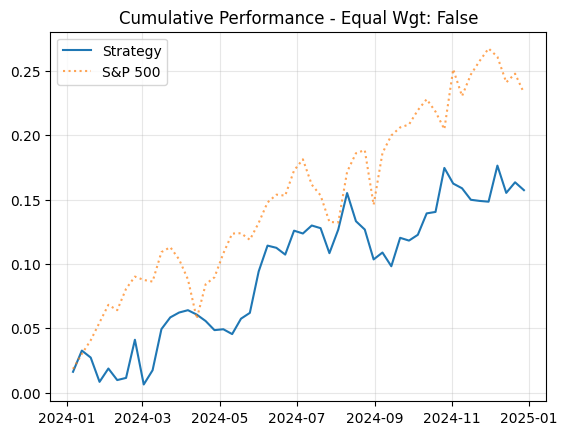

In [87]:
plot_dates = weekly_perf['week_date'] + pd.Timedelta(weeks=1)
plt.plot(plot_dates, np.cumsum(weekly_perf['port_ret']), label='Strategy')
plt.plot(plot_dates, np.cumsum(weekly_perf['sp500_ret']), label='S&P 500', linestyle=':', alpha=0.7)
plt.title(f"Cumulative Performance - Equal Wgt: {equal_weight}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


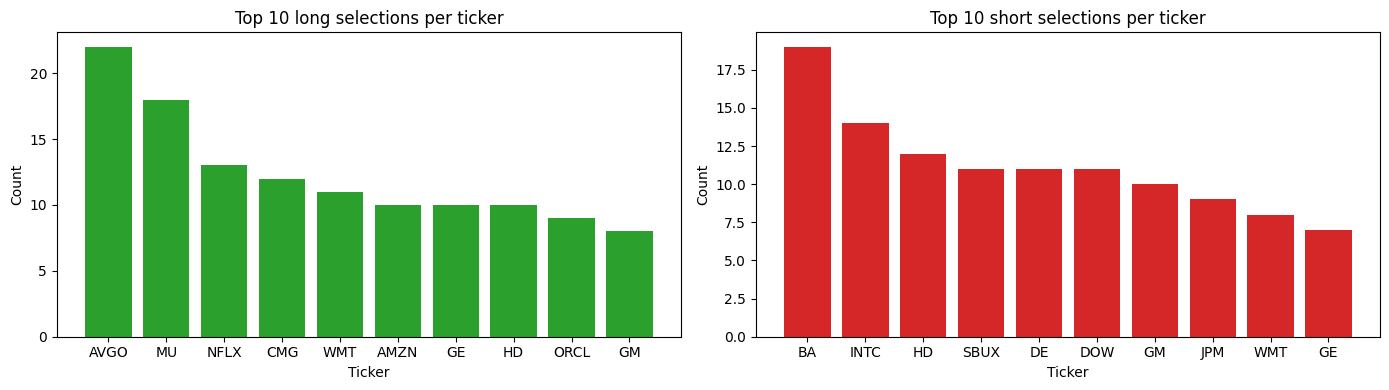

In [88]:
# Histogram: selection frequency by ticker
import matplotlib.pyplot as plt

weights = weight_panel.copy()
long_counts = (
    weights[weights['weight'] > 0]
        .groupby('TICKER')
        .size()
        .rename('long_count')
)
short_counts = (
    weights[weights['weight'] < 0]
        .groupby('TICKER')
        .size()
        .rename('short_count')
)
selection_counts = (
    pd.concat([long_counts, short_counts], axis=1)
      .fillna(0)
      .sort_values('long_count', ascending=False)
)
selection_counts.head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
top_long = long_counts.sort_values(ascending=False).head(10)
top_short = short_counts.sort_values(ascending=False).head(10)
axes[0].bar(top_long.index, top_long.values, color='tab:green')
axes[0].set_title('Top 10 long selections per ticker')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Ticker')

axes[1].bar(top_short.index, top_short.values, color='tab:red')
axes[1].set_title('Top 10 short selections per ticker')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Ticker')

plt.tight_layout()


--- Starting Sentiment vs. Momentum Analysis ---
Loading: ../data/ellen_score_2024.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1867528082.py:67: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Calculating Momentum (12-week lookback, 1-week lag)...
Aligned Observations: 1898
------------------------------
Pearson corr (Sentiment vs. Momentum): 0.2153
Spearman rank corr: 0.1951
Rank-corr t-stat:   8.66 (n=1898)
------------------------------
0.5983139638312083


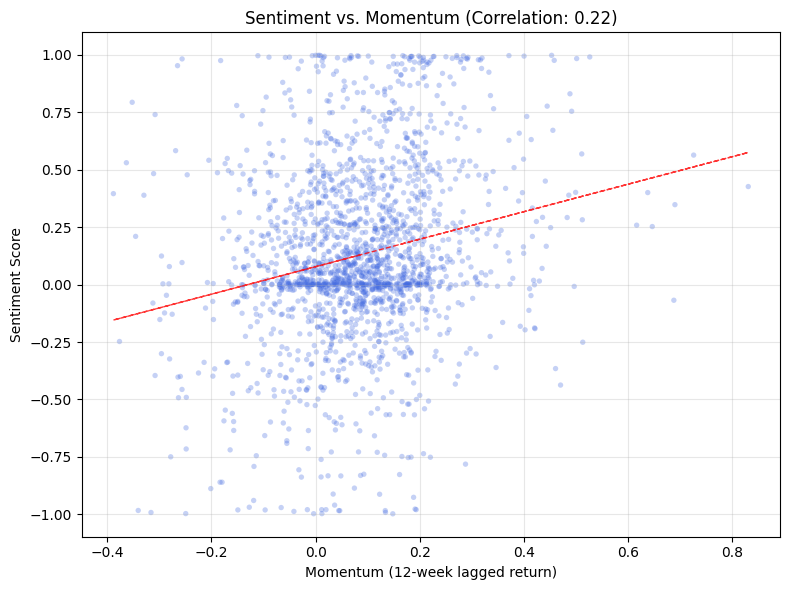


Sample Data:
  TICKER  week_date      SENT       MOM
0   AAPL 2023-12-30 -0.310508  0.086128
1   AAPL 2024-01-06 -0.107253  0.014326
2   AAPL 2024-01-13  0.090058  0.076807
3   AAPL 2024-01-20  0.187834  0.140208
4   AAPL 2024-01-27  0.167759  0.090669


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LOOKBACK_WEEKS = 12
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = "momentum/s&p500ret.csv"

# --------------------------------------------------------------------------------
# 1. DATA LOADING HELPER FUNCTIONS (Reused)
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading: {path}")
            dfs.append(pd.read_csv(path))
    
    if not dfs: return pd.DataFrame()
    combined = pd.concat(dfs, ignore_index=True)
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    if not os.path.exists(SP500_MAPPING):
        return sentiment_df
    sp500 = pd.read_excel(SP500_MAPPING)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    valid_tickers = set(sp500['Ticker'].unique())
    return sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()

def parse_sentiment_string(val):
    if isinstance(val, (int, float)): return val
    if isinstance(val, str):
        try:
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                return d.get('positive', 0) - d.get('negative', 0)
        except: return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    daily_df = daily_df.copy()
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in daily_df.columns), None)
    if not target_col: return pd.DataFrame()

    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    if isinstance(first_valid, str) and '{' in first_valid:
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)
    
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')
    
    return (daily_df.groupby(['TICKER', 'week_date'])[target_col]
            .mean().reset_index().rename(columns={target_col: 'SENT'}))

def load_stock_returns(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path): return pd.DataFrame()
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    weekly_ret = (df.groupby(['ticker', 'week_date'])['ret']
                  .apply(lambda x: (1 + x).prod() - 1)
                  .reset_index().rename(columns={'ret': 'RET', 'ticker': 'TICKER'}))
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    return weekly_ret

# --------------------------------------------------------------------------------
# 2. MOMENTUM CALCULATION
# --------------------------------------------------------------------------------

def compute_momentum(weekly_returns: pd.DataFrame, lookback_weeks: int) -> pd.DataFrame:
    """
    Calculates Momentum: Cumulative return over 'lookback_weeks', lagged by 1 week.
    """
    print(f"Calculating Momentum ({lookback_weeks}-week lookback, 1-week lag)...")
    mom_panel = weekly_returns.sort_values(['TICKER', 'week_date']).copy()
    
    # Use Log returns for additive summation
    mom_panel['logret'] = np.log1p(mom_panel['RET'].clip(lower=-0.999999))
    
    # Rolling Sum (Momentum)
    # shift(1) ensures we don't include the current week (standard momentum definition)
    mom_panel['mom_log'] = (
        mom_panel.groupby('TICKER')['logret']
                 .transform(lambda s: s.rolling(window=lookback_weeks, min_periods=lookback_weeks)
                                       .sum()
                                       .shift(1))
    )
    
    # Convert back to simple return scale
    mom_panel['MOM'] = np.expm1(mom_panel['mom_log'])
    
    return mom_panel.dropna(subset=['MOM'])[['TICKER', 'week_date', 'MOM']]

# --------------------------------------------------------------------------------
# 3. ANALYSIS EXECUTION
# --------------------------------------------------------------------------------

def run_analysis():
    print("--- Starting Sentiment vs. Momentum Analysis ---")
    
    # 1. Load Sentiment Signal
    raw_sent = load_raw_sentiment()
    if raw_sent.empty: return print("No sentiment data.")
    sent_mapped = map_entities_to_tickers(raw_sent)
    weekly_alpha = build_weekly_signal(sent_mapped)
    
    # 2. Load Market Data
    weekly_returns = load_stock_returns(STOCK_RET_PATH)
    if weekly_returns.empty: return print("No return data.")

    # 3. Calculate Momentum
    momentum_panel = compute_momentum(weekly_returns, LOOKBACK_WEEKS)
    
    # 4. Merge Sentiment and Momentum (Inner Join)
    alpha_mom = (
        weekly_alpha.merge(momentum_panel, on=['TICKER', 'week_date'], how='inner')
                    .dropna(subset=['SENT', 'MOM'])
    )
    
    if alpha_mom.empty:
        return print("No overlapping data between Sentiment and Momentum.")
    
    print(f"Aligned Observations: {len(alpha_mom)}")

    # 5. Statistics
    pearson_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'])
    spearman_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'], method='spearman')
    
    obs = len(alpha_mom)
    # Approximate t-stat for Spearman correlation
    t_stat = (spearman_corr * np.sqrt((obs - 2) / (1 - spearman_corr**2))) if obs > 2 and abs(spearman_corr) < 1 else np.nan

    print("-" * 30)
    print(f"Pearson corr (Sentiment vs. Momentum): {pearson_corr:.4f}")
    print(f"Spearman rank corr: {spearman_corr:.4f}")
    print(f"Rank-corr t-stat:   {t_stat:.2f} (n={obs})")
    print("-" * 30)

    # 6. Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(alpha_mom['MOM'], alpha_mom['SENT'], alpha=0.3, s=15, c='royalblue', edgecolors='none')
    
    # Add a trendline for visual aid
    m, b = np.polyfit(alpha_mom['MOM'], alpha_mom['SENT'], 1)
    plt.plot(alpha_mom['MOM'], m*alpha_mom['MOM'] + b, color='red', linestyle='--', alpha=0.8, linewidth=1)
    
    plt.xlabel(f'Momentum ({LOOKBACK_WEEKS}-week lagged return)')
    plt.ylabel('Sentiment Score')
    plt.title(f'Sentiment vs. Momentum (Correlation: {pearson_corr:.2f})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display head of data
    print("\nSample Data:")
    print(alpha_mom.head())


run_analysis()

--- Starting Signal Decay Analysis ---
Loading: ../data/ellen_score_2024.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_93465/1581506423.py:68: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Aligning 2343 signal rows with market data...

Computing IC for horizons 1 to 5 weeks...
   Week 1: IC = 0.0469
   Week 2: IC = 0.0435
   Week 3: IC = 0.0439
   Week 4: IC = 0.0104
   Week 5: IC = 0.0248


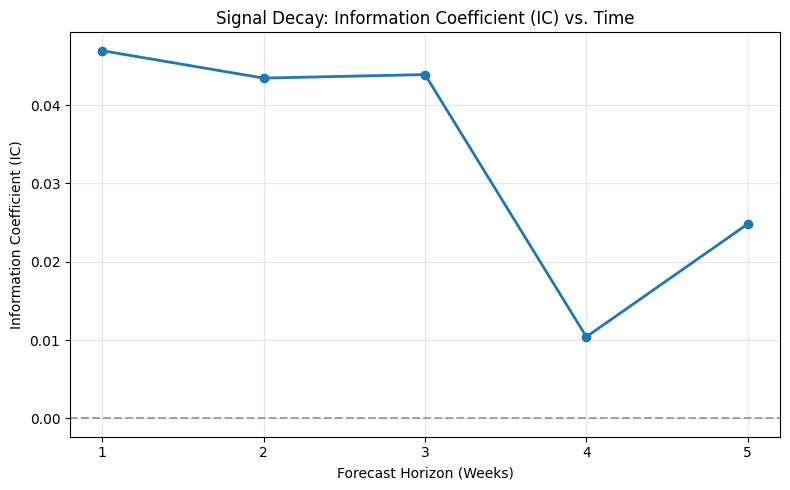

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = "momentum/s&p500ret.csv"

# --------------------------------------------------------------------------------
# 1. DATA LOADING HELPER FUNCTIONS
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading: {path}")
            dfs.append(pd.read_csv(path))
    
    if not dfs: return pd.DataFrame()
    combined = pd.concat(dfs, ignore_index=True)
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    if not os.path.exists(SP500_MAPPING):
        return sentiment_df
    sp500 = pd.read_excel(SP500_MAPPING)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    valid_tickers = set(sp500['Ticker'].unique())
    return sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()

def parse_sentiment_string(val):
    if isinstance(val, (int, float)): return val
    if isinstance(val, str):
        try:
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                return d.get('positive', 0) - d.get('negative', 0)
        except: return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    daily_df = daily_df.copy()
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    # Detect column
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in daily_df.columns), None)
    if not target_col: return pd.DataFrame()

    # Parse if string
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    if isinstance(first_valid, str) and '{' in first_valid:
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)
    
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')
    
    return (daily_df.groupby(['TICKER', 'week_date'])[target_col]
            .mean().reset_index().rename(columns={target_col: 'SENT'}))

def load_stock_returns(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path): return pd.DataFrame()
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    weekly_ret = (df.groupby(['ticker', 'week_date'])['ret']
                  .apply(lambda x: (1 + x).prod() - 1)
                  .reset_index().rename(columns={'ret': 'RET', 'ticker': 'TICKER'}))
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    return weekly_ret

# --------------------------------------------------------------------------------
# 2. CORE DECAY ANALYSIS LOGIC
# --------------------------------------------------------------------------------

def compute_future_ic(panel: pd.DataFrame, horizon: int) -> float:
    """
    Computes the average Information Coefficient (IC) for a specific forecast horizon.
    IC = Correlation between Signal(t) and Return(t+horizon)
    """
    shifted = panel.copy()
    # Shift returns backwards by 'horizon' weeks
    # Row T will now contain Signal_T and Return_{T+Horizon}
    shifted['RET_fwd'] = shifted.groupby('TICKER')['RET'].shift(-horizon)
    
    records = []
    # Compute Cross-Sectional Correlation per week
    for date, g in shifted.groupby('week_date'):
        # Need valid signal AND valid future return
        valid_g = g.dropna(subset=['SENT', 'RET_fwd'])
        
        # Need at least 5 tickers to calculate a meaningful correlation
        if len(valid_g) < 5:
            continue
            
        ic = valid_g['SENT'].corr(valid_g['RET_fwd'])
        if pd.notna(ic):
            records.append(ic)
            
    return np.mean(records) if records else np.nan

def run_analysis():
    print("--- Starting Signal Decay Analysis ---")
    
    # 1. Load Data
    raw_sent = load_raw_sentiment()
    if raw_sent.empty: return print("No sentiment data.")
    
    sent_mapped = map_entities_to_tickers(raw_sent)
    weekly_signal = build_weekly_signal(sent_mapped)
    
    weekly_returns = load_stock_returns(STOCK_RET_PATH)
    if weekly_returns.empty: return print("No return data.")

    # 2. Merge Data (Inner Join)
    print(f"Aligning {len(weekly_signal)} signal rows with market data...")
    panel = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    panel = panel.sort_values(['TICKER', 'week_date'])
    
    if panel.empty: return print("Intersection empty.")

    # 3. Compute Decay
    MAX_HORIZON = 5
    results = []
    print(f"\nComputing IC for horizons 1 to {MAX_HORIZON} weeks...")
    
    for h in range(1, MAX_HORIZON + 1):
        ic = compute_future_ic(panel, h)
        results.append({'horizon': h, 'ic': ic})
        print(f"   Week {h}: IC = {ic:.4f}")

    # 4. Visualize
    df_res = pd.DataFrame(results)
    if not df_res.empty:
        plt.figure(figsize=(8, 5))
        plt.plot(df_res['horizon'], df_res['ic'], marker='o', linewidth=2)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title("Signal Decay: Information Coefficient (IC) vs. Time")
        plt.xlabel("Forecast Horizon (Weeks)")
        plt.ylabel("Information Coefficient (IC)")
        plt.xticks(df_res['horizon'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not compute ICs (likely insufficient data points).")

if __name__ == "__main__":
    run_analysis()